## Distributed training with Built-in SageMaker Algorithms for Tabular Data 

### Setup
This notebook was created and tested on an ml.c5.2xlarge notebook instance.

Let's start by specifying:

1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
2. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the get_execution_role() call with the appropriate full IAM role arn string(s).

In [1]:
!pip install --upgrade --quiet pip

In [2]:
!pip install --upgrade --quiet torch pytorch_transformers pymysql sqlalchemy

In [ ]:
!pip install heatmapz --quiet

In [76]:
import torch
from torch import nn
import pandas as pd
import calendar
import json
import joblib
from pandas import DataFrame
from sqlalchemy import create_engine
from sklearn.preprocessing import OneHotEncoder
from pytorch_transformers import BertModel, BertConfig, BertTokenizer
import numpy as np
import os
import datetime
from numpy import float32
import warnings
warnings.filterwarnings('ignore')
import json
import os
import sys
import boto3

import requests
import logging

import sagemaker
from sagemaker import image_uris, model_uris, script_uris
from sagemaker import get_execution_role

In [77]:
role = get_execution_role()

sess = sagemaker.Session()
region = boto3.session.Session().region_name
bucket = sess.default_bucket()
sm = boto3.Session().client('sagemaker')

print("Role = {}".format(role))
print("Region = {}".format(region))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Role = arn:aws:iam::249517808360:role/SD-workshop-0614-ExecutionRole-24GQUTL7652N
Region = us-east-1


### Data explore and processing

In [6]:
data = pd.read_csv('sample.csv')

In [7]:
data.head(4)

,1.0,0.0,3253.0,65.06,3368.9764,287.4705882352941,7073.739331026527,51.0,616.0,0.27450980392156865,...,6.061688311688313,6.5,1.0.43,376.75,30.25,1.0.44,0.75.3,0.25.7,0.375.4,3.25
0,1.0,0.0,4181.0,73.350877,4366.333026,306.758621,12454.424495,58.0,752.0,0.396552,...,8.056061,8.4,1.000000,374.600000,29.800000,1.0,1.600000,0.000000,0.800000,7.000000
1,1.0,0.0,2261.0,72.935484,9622.124870,327.312500,10273.652344,32.0,291.0,0.062500,...,7.725397,7.6,1.000000,375.000000,31.800000,1.0,0.582014,0.221869,0.316387,4.476886
2,1.0,0.0,735.0,45.937500,2199.183594,244.823529,10196.968858,17.0,275.0,0.117647,...,4.633333,4.0,1.057129,385.845778,32.189208,0.0,0.582014,0.221869,0.316387,4.476886
3,1.0,0.0,2229.0,69.656250,8017.725586,247.939394,15765.693297,33.0,359.0,0.272727,...,6.109524,5.8,1.000000,359.200000,30.000000,1.0,0.000000,0.200000,0.000000,0.000000


In [8]:
data.shape

(18997, 1193)

In [9]:
data.dtypes

1.0          float64
0.0          float64
3253.0       float64
65.06        float64
3368.9764    float64
              ...   
1.0.44       float64
0.75.3       float64
0.25.7       float64
0.375.4      float64
3.25         float64
Length: 1193, dtype: object

In [ ]:
data.describe()

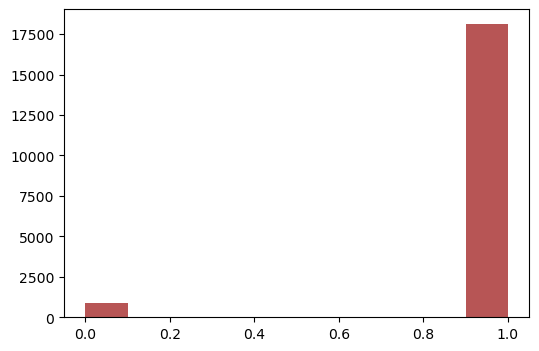

In [13]:
df = data
import matplotlib.pyplot as plt
plt.figure(figsize = (6, 4)) #新建画布
plt.hist(df['1.0'],bins = [0, 0.1,0.2, 0.5, 0.6,0.7,0.8,0.9,1],color='brown', alpha = 0.8, label = "直方图" ) #绘制直方图

plt.show()

In [15]:
df[df['1.0']>=0.98].shape[0]/df.shape[0]

0.9541506553666368

In [22]:
# percentile capping
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
quantile = df['1.0'].quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
for i in qValues:
    print("{} percentile value is {}".format(int(i*100), quantile[i]))

91 percentile value is 1.0
92 percentile value is 1.0
93 percentile value is 1.0
94 percentile value is 1.0
95 percentile value is 1.0
96 percentile value is 1.0
97 percentile value is 1.0
98 percentile value is 1.0
99 percentile value is 1.0
100 percentile value is 1.0


In [ ]:
# Frequency tables for each categorical feature
'''
for column in df.select_dtypes(include=["object",'category']).columns:
    display(pd.crosstab(index=df[column], columns="% observations", normalize="columns"))
'''

# Histograms for each numeric features
#display(df.describe())
#%matplotlib inline
#hist = df.hist(bins=30, sharey=True, figsize=(30, 30))

In [17]:
print(df.isnull().sum())

1.0          7
0.0          7
3253.0       7
65.06        7
3368.9764    7
            ..
1.0.44       8
0.75.3       8
0.25.7       8
0.375.4      8
3.25         8
Length: 1193, dtype: int64


In [18]:
df.dropna(inplace=True)

In [19]:
print(df.isnull().sum())

1.0          0
0.0          0
3253.0       0
65.06        0
3368.9764    0
            ..
1.0.44       0
0.75.3       0
0.25.7       0
0.375.4      0
3.25         0
Length: 1193, dtype: int64


In [24]:
df.to_parquet('df.parquet')

In [ ]:
df_p = pd.read_parquet('df.parquet')
df_p

In [86]:
print(df_p.isnull().sum())

1.0          0
0.0          0
3253.0       0
65.06        0
3368.9764    0
            ..
1.0.44       0
0.75.3       0
0.25.7       0
0.375.4      0
3.25         0
Length: 1193, dtype: int64


In [ ]:
#split data to train and test dataset
from sklearn.model_selection import train_test_split

X = data_set.drop('order', axis=1).fillna(0)
y = data_set['order'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Upload data to S3

In [91]:
#upload train data to your own bucket
prefix = "define_by_you"
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/df.parquet")
).upload_file("df.parquet")
'''
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/data.csv")
).upload_file("validation.csv")
'''

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


'\nboto3.Session().resource("s3").Bucket(bucket).Object(\n    os.path.join(prefix, "validation/data.csv")\n).upload_file("validation.csv")\n'

In [92]:
prefix = "7k7k"
training_data_uri = 's3://{}/{}/train/df.parquet'.format(bucket,prefix)
#test_data_uri = 's3://{}/{}/validation/data.csv'.format(bucket,prefix)
print("train data location:"+training_data_uri)
#print("test data location:"+test_data_uri)

train data location:s3://sagemaker-us-east-1-249517808360/7k7k/train/df.parquet


### Model Training

1. distributed training with cpu

| Model | Problem Type | Model ID|
| :-- | :-- | :-- |
| LightGBM | Classification | lightgbm-classification-model |
| LightGBM |Regression | lightgbm-regression-model |
| CatBoost | Classification | catboost-classification-model |
| CatBoost | Regression | catboost-regression-model |
| AutoGluon-Tabular | Classification | autogluon-classification-ensemble |
| AutoGluon-Tabular |Regression | autogluon-regression-ensemble |
| TabTransformer | Classification | pytorch-tabtransformerclassification-model |
| TabTransformer | Regression | pytorch-tabtransformerregression-model |




In [93]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = "lightgbm-classification-model", "*", "training"
training_instance_type = "ml.m5.2xlarge"

In [94]:
# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type
)

# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)

train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

In [96]:
# Sample training data is available in this bucket
training_dataset_s3_path = training_data_uri
# validation_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}/validation"

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-tabular-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

In [102]:
from sagemaker.inputs import TrainingInput
s3_input_train = TrainingInput(
    training_data_uri, distribution= "FullyReplicated", content_type="application/x-parquet"
)
'''
s3_input_validation = TrainingInput(
    test_data_uri, distribution= "FullyReplicated", content_type="application/x-parquet"
)
'''

'\ns3_input_validation = TrainingInput(\n    test_data_uri, distribution= "FullyReplicated", content_type="application/x-parquet"\n)\n'

In [98]:
from sagemaker import hyperparameters

# Retrieve the default hyperparameters for training the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

#### 分布式训练相关参数参考

In [99]:
# [Optional] Override default hyperparameters with custom values

hyperparameters["num_boost_round"] = "500"
hyperparameters["metric"] = "auc"
hyperparameters["tree_learner"] = "voting"  # use AllReduce method for distributed training
#hyperparameters["tree_learner"] = "data"

del hyperparameters[
    "early_stopping_rounds"
]  
# current distributed training with early stopping has some issues. 
# See https://github.com/microsoft/SynapseML/issues/728#issuecomment-1221599961
# thus it is disabled for distributed training.


print(hyperparameters)

from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

{'num_boost_round': '500', 'metric': 'auto', 'learning_rate': '0.009', 'num_leaves': '67', 'feature_fraction': '0.74', 'bagging_fraction': '0.53', 'bagging_freq': '5', 'max_depth': '11', 'min_data_in_leaf': '26', 'max_delta_step': '0.0', 'lambda_l1': '0.0', 'lambda_l2': '0.0', 'boosting': 'gbdt', 'min_gain_to_split': '0.0', 'scale_pos_weight': '1.0', 'tree_learner': 'data', 'feature_fraction_bynode': '1.0', 'is_unbalance': 'False', 'max_bin': '255', 'num_threads': '0', 'verbosity': '1', 'use_dask': 'False'}


In [103]:


training_job_name = name_from_base(f"built-in-algo-{train_model_id}-training")

# spot training hp define
use_spot_instances = True
max_run = 3600
max_wait = 7200 if use_spot_instances else None
checkpoint_s3_uri = (
    "s3://{}/{}/checkpoints/{}".format(bucket, prefix, job_name) if use_spot_instances else None
)
print("Checkpoint path:", checkpoint_s3_uri)



# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=2, # for distributed training, specify an instance_count greater than 1
    instance_type=training_instance_type,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    #use_spot_instances=use_spot_instances,
    #max_run=max_run,
    #max_wait=max_wait,
    #checkpoint_s3_uri=checkpoint_s3_uri,
)


# Launch a SageMaker Training job by passing the S3 path of the training data
tabular_estimator.fit(
    {
        "train": s3_input_train,
        #"validation": test_data_uri,
    }, logs=True, job_name=training_job_name#, wait=False
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: built-in-algo-lightgbm-classification-m-2023-11-13-13-58-21-881


2023-11-13 13:58:22 Starting - Starting the training job...
2023-11-13 13:58:38 Starting - Preparing the instances for training......
2023-11-13 13:59:39 Downloading - Downloading input data...
2023-11-13 14:00:04 Training - Downloading the training image...
2023-11-13 14:00:25 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-11-13 14:00:42,833 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-11-13 14:00:42,835 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-11-13 14:00:42,844 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-11-13 14:00:42,846 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-11-13 14:00:43,400 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:

2. distributed training with gpu
- XGB：
    - SageMaker XGBoost version 1.2-2 or later supports GPU training. Despite higher per-instance costs, GPUs train more quickly, making them more cost effective.
    - SageMaker XGBoost version 1.2-2 or later supports P2, P3, G4dn, and G5 GPU instance families.
    - SageMaker XGBoost version 1.7-1 or later supports P3, G4dn, and G5 GPU instance families. Note that due to compute capacity requirements, version 1.7-1 or later does not support the P2 instance family.
    - To take advantage of GPU training, specify the instance type as one of the GPU instances (for example, P3) and set the 'tree_method' hyperparameter to gpu_hist in your existing XGBoost script.
    
- Distributed training with single-GPU instances

    - SageMaker XGBoost versions 1.2-2 through 1.3-1 only support single-GPU instance training. This means that even if you select a multi-GPU instance, only one GPU is used per instance.

    - If you use XGBoost versions 1.2-2 through 1.3-1, or if you do not need to use multi-GPU instances, then you must divide your input data between the total number of instances. For more information, see Divide input data across instances.

    - Note
        - Versions 1.2-2 through 1.3-1 of SageMaker XGBoost only use one GPU per instance even if you choose a multi-GPU instance.

- Distributed training with multi-GPU instances
    - Starting with version 1.5-1, SageMaker XGBoost offers distributed GPU training with Dask. With Dask you can utilize all GPUs when using one or more multi-GPU instances. Dask also works when using single-GPU instances.

    - Train with Dask using the following steps:

        - Either omit the 'distribution' parameter in your TrainingInput or set it to FullyReplicated.
        - When defining your hyperparameters, set 'use_dask_gpu_training' to "true".
- Catboost:
    - byoc

In [104]:
# sample code for converting parquet data
'''
import pyarrow
%%time
import numpy as np
import pandas as pd
from sklearn.datasets import load_svmlight_file
# Split the downloaded data into train/test dataframes
train, test = np.split(data.sample(frac=1), [int(0.8 * len(data))])
# requires PyArrow installed
train.to_parquet("77_train.parquet")
test.to_parquet("77_test.parquet")
'''

UsageError: Line magic function `%%time` not found.


### define data source and image

In [ ]:
prefix = "77_dis"
training_data_uri = 's3://{}/{}/train/7k7k_train.parquet'.format(bucket,prefix)
test_data_uri = 's3://{}/{}/validation/7k7k_test.parquet'.format(bucket,prefix)

In [106]:
container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.7-1")
display(container)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1'

### 用sagemaker 的Traininput 定义训练数据channel，指定数据分发方式，格式

In [107]:
from sagemaker.inputs import TrainingInput
s3_input_train = TrainingInput(
    training_data_uri, distribution= "FullyReplicated", content_type="application/x-parquet"
)
s3_input_validation = TrainingInput(
    test_data_uri, distribution= "FullyReplicated", content_type="application/x-parquet"
)

In [110]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=2,
    instance_type="ml.p3.2xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
    # dependency = equirement.txt
)

xgb.set_hyperparameters(
    max_depth=6,
    eta=0.2,
    gamma=4,
    min_child_weight=7.5,
    subsample=0.8,
    verbosity=0,
    objective="reg:squaredlogerror",
    num_round=500,
    use_dask_gpu_training = "true",
    tree_method = "gpu_hist"
)
# Used only if tree_method is set to gpu_hist.
# deterministic_histogram:Default value: "true"
# Used only if tree_method is set to hist or gpu_hist.
# single_precision_histogram:Default value: "false"


xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-13-14-52-46-297


2023-11-13 14:52:46 Starting - Starting the training job...
2023-11-13 14:53:12 Starting - Preparing the instances for training.........
2023-11-13 14:54:32 Downloading - Downloading input data...
2023-11-13 14:55:02 Training - Downloading the training image...
2023-11-13 14:55:33 Training - Training image download completed. Training in progress...[2023-11-13 14:55:57.214 ip-10-2-113-198.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-11-13 14:55:57.243 ip-10-2-113-198.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-11-13:14:55:57:INFO] Imported framework sagemaker_xgboost_container.training
[2023-11-13:14:55:57:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2023-11-13:14:55:57:INFO] Failed to parse hyperparameter tree_method value gpu_hist to Json.
Returning the value itself
[2023-11-13:14:55:57:INFO] Running XGBoost Sagemaker in algorithm mode
[2023-11-13:14:55

In [111]:
print(xgb.latest_training_job.job_name)

sagemaker-xgboost-2023-11-13-14-52-46-297


### Model deploy

In [2]:
import boto3
import json 
import sagemaker

sm_client = boto3.client('sagemaker')

role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


通过查找过去训练任务的方式恢复训练好的模型的所在位置

In [3]:
import pprint
import json
from datetime import date, datetime
pp = pprint.PrettyPrinter(indent=4, depth=4)

sagemaker_client = boto3.client('sagemaker')

response = sagemaker_client.list_training_jobs(SortBy='CreationTime',
                                               NameContains='lightgbm',
                                               CreationTimeAfter=datetime(2022, 12, 1))
lgm_trainjob_name = response['TrainingJobSummaries'][0]['TrainingJobName']

response = sagemaker_client.list_training_jobs(SortBy='CreationTime',
                                               NameContains='xgboost',
                                               CreationTimeAfter=datetime(2022, 12, 1))
xgb_trainjob_name = response['TrainingJobSummaries'][0]['TrainingJobName']

In [ ]:
output_path = 's3://sagemaker-us-east-1-2xxxxxxx60/example-tabular-training/output'
lgm_model_uri = output_path +"/" + lgm_trainjob_name + '/output/model.tar.gz'

In [ ]:
output_path = "s3://{}/{}/output".format(bucket, prefix)
xgb_model_uri = output_path +"/" + xgb_trainjob_name + '/output/model.tar.gz'
xgb_model_uri

部署训练好的模型，部署的过程需要等待十几分钟的时间

In [ ]:
from sagemaker.model import Model
from sagemaker.serializers import CSVSerializer

container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.7-1")

# modify the uri with your model uri
xgb = Model(image_uri=container, 
            model_data=xgb_model_uri, 
            role=role)
                 
xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m5.xlarge", serializer=CSVSerializer()
)

In [ ]:
# modify the uri with your model uri
lgm = Model(image_uri=deploy_image_uri, 
            model_data=lgm_model_uri, 
            role=role)
lgm_predictor = lgm.deploy(
    initial_instance_count=1, endpoint_name = endpoint_name, instance_type=inference_instance_type, serializer=CSVSerializer()
)

### 通过describe endpoint的接口查询推理节点部署情况
 - 文档：https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/describe_endpoint.html# 

返回的 “Status” 字段为部署的状态

### Batch Inference
API相关文档： https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/create_transform_job.html#

In [4]:
#### prediction with 200,000 trees
import sagemaker as sage
from time import gmtime, strftime
sess = sage.Session()

#best_job =tuner.best_training_job()
#print("Best Job name:" , best_job)

attached_estimator = sage.estimator.Estimator.attach(xgb_trainjob_name)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml

2023-11-13 14:56:40 Starting - Preparing the instances for training
2023-11-13 14:56:40 Downloading - Downloading input data
2023-11-13 14:56:40 Training - Training image download completed. Training in progress.
2023-11-13 14:56:40 Uploading - Uploading generated training model
2023-11-13 14:56:40 Completed - Training job completed


In [ ]:
output_path ='s3://'+bucket+'/sagemaker/DEMO/data/test-predictions/'
input_path  ='s3://'+bucket+'/sagemaker/DEMO/data/test/'

transformer = attached_estimator.transformer(instance_count=1, 
                                             instance_type='ml.p2.xlarge', 
                                             assemble_with='Line', 
                                             accept='text/csv',
                                             max_payload=1,
                                             output_path=output_path,
                                             env = {'SAGEMAKER_MODEL_SERVER_TIMEOUT' : '3600' })
transformer.transform(input_path, 
                      content_type='text/csv',
                      split_type='Line')